In [46]:
import numpy as np
from ddm import DDM
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
from tifffile import imread, imwrite

In [11]:
# make sure images are in gray scale && dimensions aren't not too large (512x512 is ideal)
sampling_time = 0.07
ntau = 700
# list of files to analyze
samples = ["sample2.tif", "sample4.tif", "sample5.tif"]

In [ ]:
# perform ddm
for sample in samples:
    print(f"Analyzing {sample} ...")
    stack = imread(sample).astype(np.double)
    ddmstack = DDM(stack, ntau, sampling_time)
    result = ddmstack.compute()
    imwrite( sample.split('.')[0]  + "_ddm.tif", result)

Analyzing sample2.tif ...
FFT transform ...
Computing DDM ...
Analyzing sample4.tif ...
FFT transform ...
Computing DDM ...
Analyzing sample5.tif ...
FFT transform ...
Computing DDM ...


In [12]:
# fitting part

# image structure function, to fit
def D(t, A, B, freq):
    return A * (1 - np.exp(-t*freq)) + B
D = np.vectorize(D)

ddms = ["sample2_ddm.tif"]#, "sample4_ddm.tif"]#, "sample5_ddm.tif"]
freqs = np.zeros(512**2)

In [12]:
for ddm in ddms:
    stack = imread(ddm).astype(np.double)
    _,w,h = stack.shape
    centerx = w//2
    centery = h//2 
    for j in range(h):
        for i in range(w):
            #q = np.sqrt((j - centery)**2 + (i - centerx)**2)
            #freqs[j,i] = curve_fit(D, np.linspace(0, ntau*sampling_time, ntau),
                                     stack[:,j,i], p0=[stack[-1,j,i], 1, 0])
            #imwrite(ddm.split(".")[0] + "_freqs.tif", freqs)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [ ]:
def radial_profile(data):
    y0,x0 = data.shape

    x,y = np.meshgrid(np.arange(data.shape[1]),np.arange(data.shape[0]))
    R = np.sqrt( (y-y0//2)**2 + (x-x0//2)**2)

    f = lambda r : data[(R >= r-.5) & (R < r+.5)].mean()
    maxr = data.shape[1] - x0//2
    r = np.linspace(1, maxr, num=maxr)

    mean = np.vectorize(f)(r)
    return r,mean

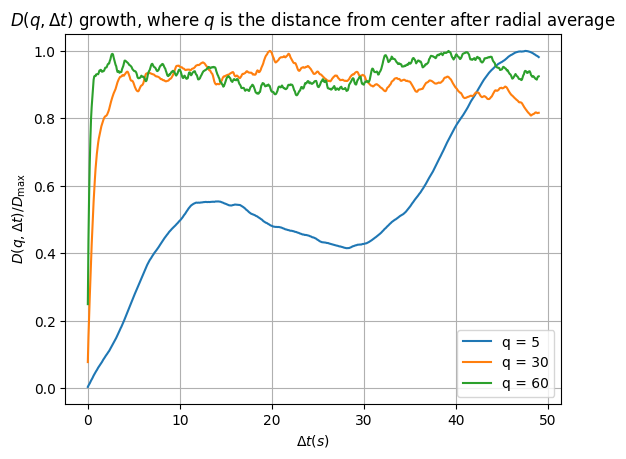

In [25]:
selected_qs = [5, 30, 60]
radials = []
for ddm in ["sample2_ddm.tif"]:
    stack = imread(ddm).astype(np.double)
    for r in selected_qs:
        rs = []
        for t in range(ntau):
            _,mean = radial_profile(stack[t,:,:])
            rs.append( mean[r] )
        radials.append(rs)


times = np.linspace(0, ntau*sampling_time, ntau)
for i in range(len(selected_qs)):
    radials[i] = np.array(radials[i])
    plt.plot(times, radials[i]/np.max(radials[i]))

plt.legend([f"q = {q}" for q in selected_qs])
plt.xlabel(r"$\Delta t (s)$")
plt.ylabel(r"$D(q,\Delta t)/D_{\text{max}}$")
plt.title(r"$D(q,\Delta t)$ growth, where $q$ is the distance from center after radial average")
plt.grid()
plt.show()

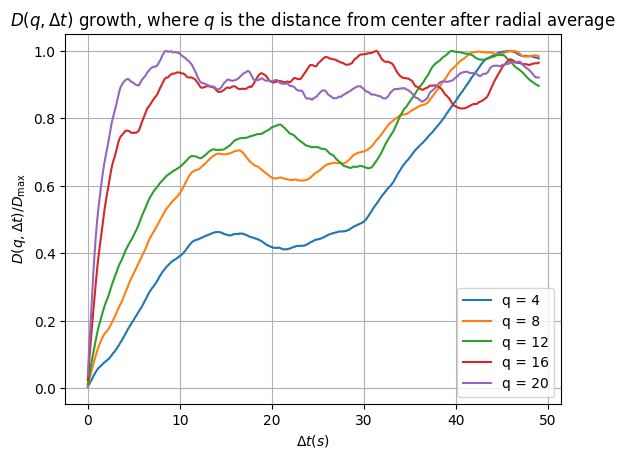

In [26]:
selected_qs = [4, 8, 12, 16, 20]
radials = []
for ddm in ["sample2_ddm.tif"]:
    stack = imread(ddm).astype(np.double)
    for r in selected_qs:
        rs = []
        for t in range(ntau):
            _,mean = radial_profile(stack[t,:,:])
            rs.append( mean[r] )
        radials.append(rs)


times = np.linspace(0, ntau*sampling_time, ntau)
for i in range(len(selected_qs)):
    radials[i] = np.array(radials[i])
    plt.plot(times, radials[i]/np.max(radials[i]))

plt.legend([f"q = {q}" for q in selected_qs])
plt.xlabel(r"$\Delta t (s)$")
plt.ylabel(r"$D(q,\Delta t)/D_{\text{max}}$")
plt.title(r"$D(q,\Delta t)$ growth, where $q$ is the distance from center after radial average")
plt.grid()
plt.show()

In [19]:
ts = np.linspace(0, ntau*sampling_time, ntau)
A,nu,B = curve_fit(D, ts, radials, p0=[radials[-1], 1, 0])[0]
print(f"A = {A}, B = {B}, nu = {nu}")

A = 4.080291870493126, B = 1.2242777328202132, nu = 0.4762493218779394


In [31]:
selected_qs = range(12, 30)
radials = []
for ddm in ["sample2_ddm.tif"]:
    stack = imread(ddm).astype(np.double)
    for r in selected_qs:
        rs = []
        for t in range(ntau):
            _,mean = radial_profile(stack[t,:,:])
            rs.append( mean[r] )
        radials.append(rs)

ts = np.linspace(0, ntau*sampling_time, ntau)
As = []
Bs = []
nus = []
for i in range(len(radials)):
    Dth = 10**-13
    A,nu,B = curve_fit(D, ts, rs, p0=[radials[i][-1], Dth*selected_qs[i]**2, 0])[0]
    As.append(A)
    Bs.append(B)
    nus.append(nu)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


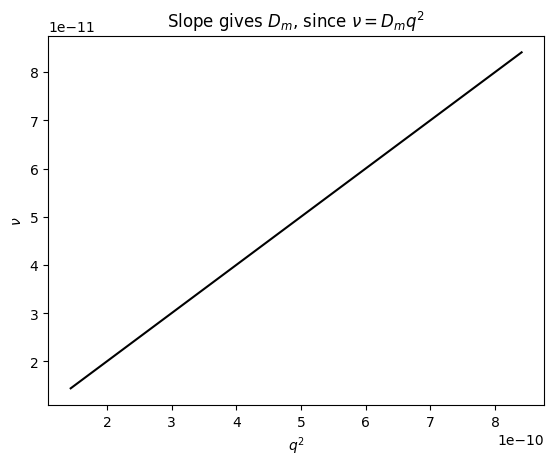

In [63]:
# 11th element is weird
plt.plot( (np.delete(selected_qs, 11)*10**-6)**2, np.delete(nus, 11), 'k')
plt.xlabel("$q^2$")
plt.ylabel(r"$\nu$")
plt.title(r"Slope gives $D_m$, since $\nu = D_m q^2$")
plt.show()

In [65]:
qs = np.delete(selected_qs, 11)
frequencies = np.delete(nus, 11)
calibration = 170/1280

Dm, _,_,_,_ = linregress((calibration*qs)**2, frequencies)
print(f"D_m = {Dm}")

D_m = 5.669204152249134e-12
